In [10]:
import mne
import numpy as np
import os
import fnmatch
import pandas as pd
import sklearn
import sigproc
import decoding
import openpyxl
from matplotlib import pyplot as plt
import utils
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import settings
from joblib import Memory, Parallel, delayed
import mne.stats as stats 
import pickle
import scipy

In [2]:
# analysis settings
data_filepath = r"c:\\sync_folder\\TSRlearn\\Data\\"
os.chdir(data_filepath)
subject_name = "pilot_sianna"
subject_list = [subject_name]

data_path = os.path.join(data_filepath + subject_name)

ex_per_fold = 1

clf_params = {
    "C": 1 / 0.006,
    "max_iter": 1000,
    "penalty": "l1",
    "solver": "liblinear",
}

clf = LogisticRegression(**clf_params)

# concepts
concepts = [
    "beetle","berry","bicycle","bird","box","car","chair","coffee","dog","face","fish",
    "guitar","hammer","hand","house","jacket","pencil","phone","pizza","plane","tree"
]
colors_list = ["#54478c","#2c699a","#048ba8","#0db39e","#16db93","#83e377","#b9e769","#efea5a","#f1c453","#f29e4c",
               "#264653","#287271","#2a9d8f","#8ab17d","#babb74","#e9c46a","#efb366","#f4a261","#ee8959","#e76f51",
               "#d23f0f"]


Procedure
1. Train and test on all possible timepoint combinations (with get_best_timepoint, leave one out)
2. find the best timepoint for localiser training
3. plot timecourse of decoding accuracy (averaged across concept-decoders)

load the pre-processed and segmented data

In [3]:
all_files = os.listdir(data_path)

preprocessed_files = fnmatch.filter(all_files, '*epoched*.fif')
data_preprocessed = mne.read_epochs((data_path + '//' + preprocessed_files[0]), verbose=False)
data_preprocessed


C:\Users\sianna.groesser\AppData\Local\Temp\ipykernel_14172\230916490.py:4: RuntimeWarning: This filename (c:\\sync_folder\\TSRlearn\\Data\\pilot_sianna//pilot1_Sianna_epoched_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  data_preprocessed = mne.read_epochs((data_path + '//' + preprocessed_files[0]), verbose=False)


<EpochsFIF | 840 events (all good), -0.1 – 0.5 s (baseline off), ~125.2 MiB, data loaded,
 '1': 40
 '2': 40
 '3': 40
 '4': 40
 '5': 40
 '6': 40
 '7': 40
 '8': 40
 '9': 40
 '10': 40
 and 11 more events ...>

Prepare the MEG Data for classification

In [4]:
data_meg = data_preprocessed.get_data()
data_y = data_preprocessed.events[:,2]

# split by sensors 
picks_grad = mne.pick_types(data_preprocessed.info, meg='grad')
picks_mag  = mne.pick_types(data_preprocessed.info, meg='mag')

# slice the data
data_grad = data_meg[:, picks_grad, :]   
data_mag  = data_meg[:, picks_mag, :] 

# rescale MEG data
grad_rescaled = settings.rescale_meg(data_grad)

mag_rescaled  = settings.rescale_meg(data_mag)

# 
data_x = np.hstack((grad_rescaled, mag_rescaled))

Compute Decoding Accuracy for all classifiers and plot

In [ ]:
## Calculation of best timepoint and leave-one-out cross-validation
res = utils.get_best_timepoint(
       data_x, data_y, clf=clf, subj=subject_name, ex_per_fold=ex_per_fold,
       return_preds=True
   )

df_out=res[0]

Peak (averaged) accuracy: 0.08214285714285714
Peak time (ms): 280


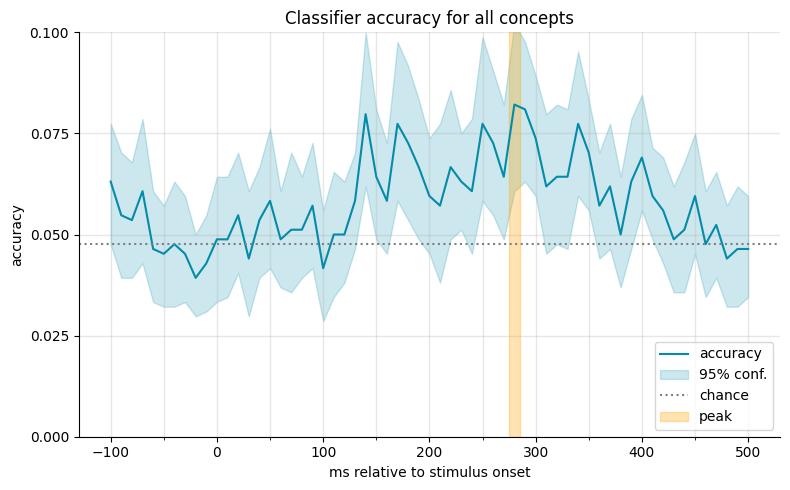

In [46]:

# mean across folds at each timepoint
g = df_out.groupby("timepoint", sort=True)["mean_accuracy"]
curve_mean = g.mean()
curve_ci   = 1.96 * g.std(ddof=1) / np.sqrt(g.count())  # optional for CI

peak_time = curve_mean.idxmax()
peak_acc  = curve_mean.max()

print("Peak (averaged) accuracy:", peak_acc)
print("Peak time (ms):", peak_time)


# plot predictions over time: one subplot per classifier 
fig = plt.figure(figsize=(8,5))
ax = fig.subplots()
sns.despine()


utils.plot_decoding_accuracy(
    df_out, x="timepoint", y="mean_accuracy", ax=ax, color=colors_list[2]
)
ax.set(
    xlabel="ms relative to stimulus onset",
    ylabel="accuracy",
    title=f"Classifier accuracy for all concepts",
)
ax.set_ylim(0, 0.1)
ax.set_yticks([0, 0.025, 0.05, 0.075,0.1])
# draw the band at the correct place
ax.axvspan(peak_time - 5, peak_time + 5, alpha=0.3, color="orange")

ax.legend(["accuracy", "95% conf.", "chance", "peak"], loc="lower right")

plt.tight_layout()
plt.pause(0.1)
fig.savefig(f"decoding_accuracy_pilot1.png", bbox_inches="tight")

Count how many times correct classification occured for each concept

In [ ]:
# split predictions by trials with the same concept and compute accuracy
preds = res[1]

labels = np.unique(data_y) # shape (n_trials,)
n_time, n_trials = preds.shape

# trials-by-label mask: 
mask_labtr = (data_y[:, None] == labels[None, :])

# correctness trials-by-labels mask
correct_labtr = (preds[:, :, None] == labels[None, None, :])

# correct counts per time x label: 
num_correct_labtr = (correct_labtr & mask_labtr[None, :, :]).sum(axis=1)

# trials per label: 
denom_ntrials = mask_labtr.sum(axis=0)

# --- result: per-label accuracy per timepoint in [0,1], shape (T, K) ---
per_label_acc = num_correct_labtr / denom_ntrials

Plot accuracy split by concept (oonly correct classifications for trials with this concept)

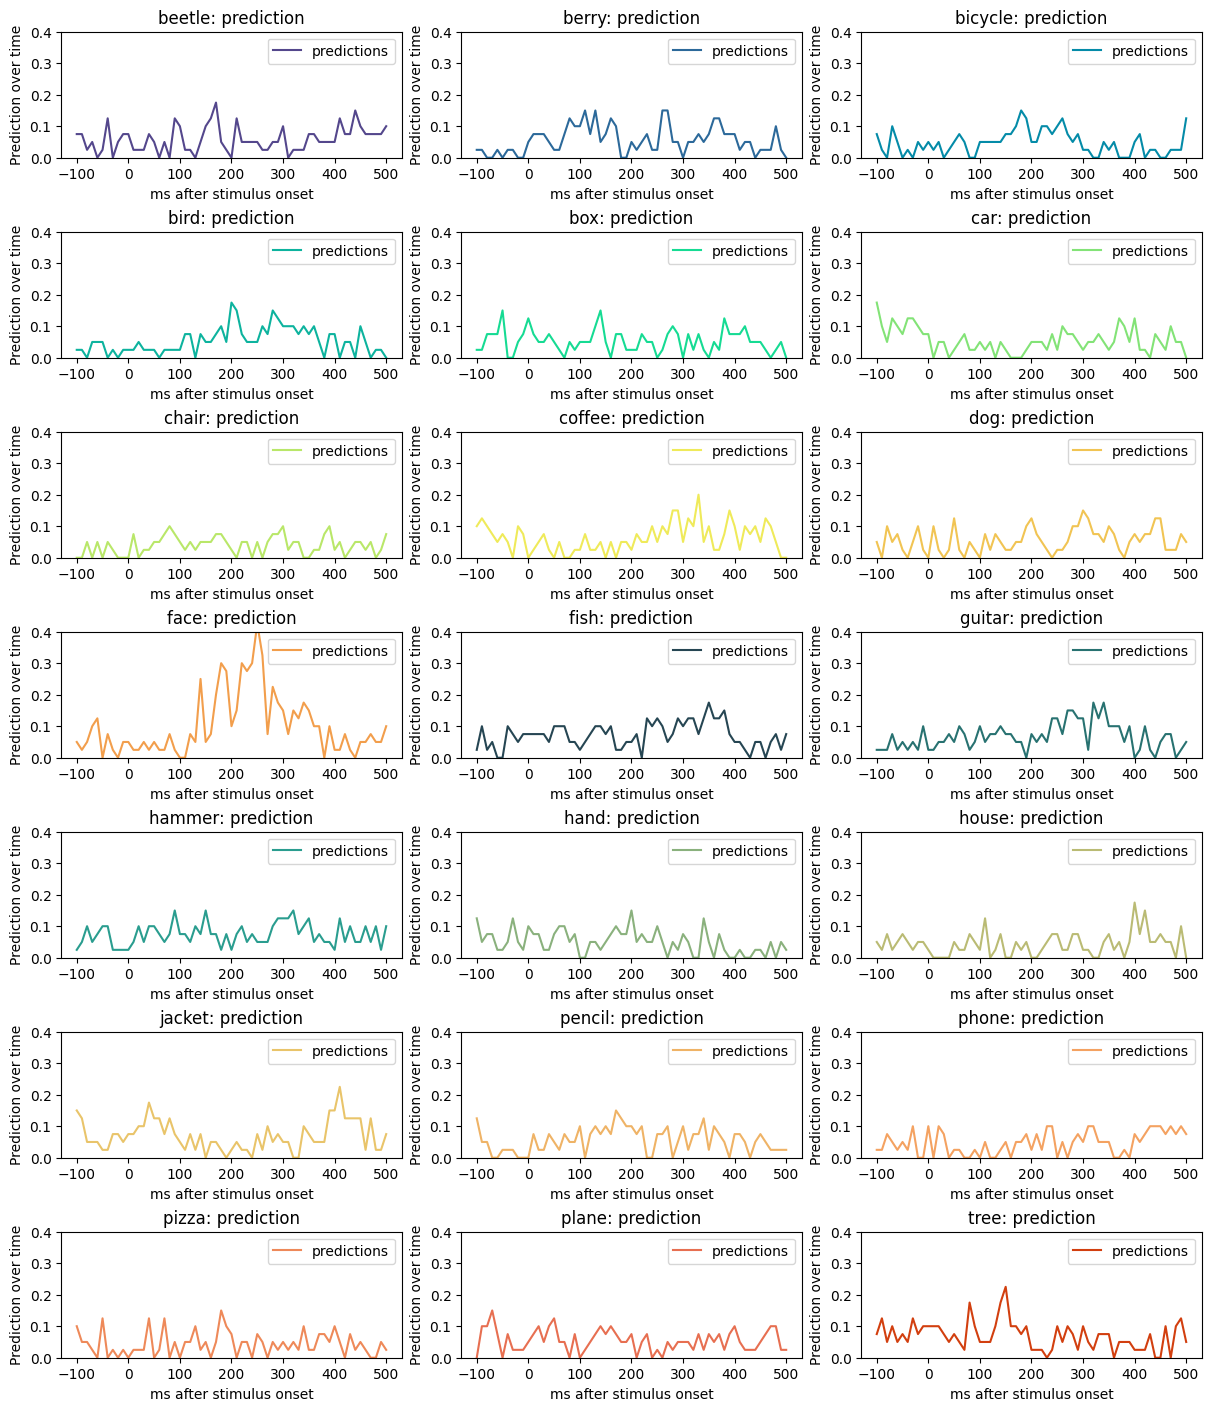

In [ ]:
   
# start plotting of mean decoding accuracy

# plot predictions over time: one subplot per classifier 
fig = plt.figure(figsize=(12, 14), constrained_layout=True)
ax = fig.subplots(7,3)
axes_flat = ax.flat  
# sns.despine()
time_vector = np.linspace(-100, 500, n_time)
for i, concept in enumerate(concepts):
    curr_ax = axes_flat[i]
    prediction = per_label_acc[:,i]

    curr_ax.plot(time_vector, prediction, color=colors_list[i])

    curr_ax.set(
        xlabel="ms after stimulus onset",
        ylabel="Prediction over time",
        title=f"{concept}: prediction",
    )
    curr_ax.set_ylim(0, 0.4)


plt.show()
fig.savefig(f"decoding_predictions_pilot1_seperate.png", bbox_inches="tight")

Cool heatmap

In [22]:
# limit time win around stim onset in data_x so it doesn't run forever
data_x_new = data_x[:, :, 11:31] # from 0 to 200 ms after stim 
len_times = 20
ms_start = 0
ms_end = 200

In [89]:
## plot heatmap for decoding accuracy for each train and test timepoint combination

# calculate time by time decoding heatmap from localizer
# basically: How well can a clf trained on t1 predict t2 of the localizer
# maps_localizer = utils.get_decoding_heatmap(clf, data_x_new, data_y, ex_per_fold=ex_per_fold)

# # save
# with open("heatmap_results_pilot1.pkl", "wb") as f:
#     pickle.dump(maps_localizer, f)

heatmap_matrix = maps_localizer[1]
results = maps_localizer[0]

# zscore maps for statistics
maps_loc_norm = np.array(heatmap_matrix) - np.mean(heatmap_matrix)
maps_loc_norm = maps_loc_norm / maps_loc_norm.std()

# perform cluster permutation testing
t_thresh = scipy.stats.distributions.t.ppf(1 - 0.05, df=len(heatmap_matrix) - 1)
t_clust, clusters1, p_values1, H0 = mne.stats.permutation_cluster_1samp_test(
    maps_loc_norm,
    tail=1,
    n_jobs=None,
    threshold=t_thresh,
    adjacency=None,
    n_permutations=1000,
    out_type="mask",
)

# select significant clusters
sig_clusters = [cl for cl, p in zip(clusters1, p_values1) if p < 0.05]

# make a boolean mask with the same shape as the image
mask = np.zeros_like(heatmap_matrix, dtype=bool)
for cl in sig_clusters: 
    if isinstance(cl, tuple):
        mask[cl] = True
    

# create mask from cluster for all clusters of p<0.05
clusters_sum1 = (np.array(clusters1)[p_values1 < 0.05]).sum(0)



stat_fun(H1): min=-2.2114107443322735 max=2.293083423939763
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 999/999 [00:00<00:00, 8038.21it/s]


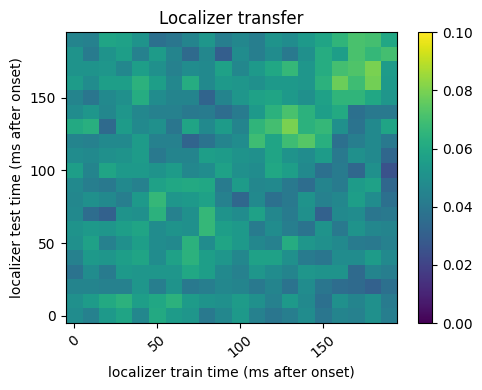

In [90]:
# now plot the heatmaps with masking using MNE visualization functions
fig = plt.figure(figsize=[5, 4])
axs = fig.subplots()
x = mne.viz.utils._plot_masked_image(
    axs,
    heatmap_matrix,
    times=range(len_times),
    mask=mask,
    cmap="viridis",
    mask_style="contour",
    vmin=0.0,
    vmax=0.1,
)
plt.colorbar(x[0])


title = "Localizer transfer"
axs.set_title(title)
times = np.arange(ms_start, ms_end, 50)  # t
axs.set_xticks(np.arange(0, len_times, 5), times, rotation=40)
axs.set_yticks(np.arange(0, len_times, 5), times)
axs.set_xlabel("localizer train time (ms after onset)")
axs.set_ylabel("localizer test time (ms after onset)")

fig.tight_layout()
fig.savefig("localiser_classifier_transfer_pilot1.png")